In [1]:
library(Seurat)
library(Matrix)
library(dplyr)
library(tibble)
library(viridis)
inputdir <- "./load_files/"
outputdir <- "./report/"

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite



In [2]:
## Genearte region order based on expression
load(file = paste0("../region_differences/load_files/", "Smooth_by_region_tRG.Rdata"))  ##trg_smt, trg_meta, 
head(trg_meta)

,region,pseudotime,cluster
,<chr>,<dbl>,<chr>
FC|0.533835,FC,0.533835,NEP RSPO3 TEX15
FC|0.657051,FC,0.657051,NEP RSPO3 TEX15
FC|0.780267,FC,0.780267,NEP RSPO3 TEX15
FC|0.903483,FC,0.903483,NEP RSPO3 TEX15
FC|1.026699,FC,1.026699,NEP RSPO3 TEX15
FC|1.149916,FC,1.149916,NEP RSPO3 TEX15


In [3]:
## Reorder trg_smt columns, put TC after OC
trg_smt_new_ord <- lapply(c("FC", "MSC", "OcC", "TC"), function(x) {
    yy <- colnames(trg_smt)[grepl(paste0("^", x, "\\|"), colnames(trg_smt))]
    return(yy)
    }) %>%
    unlist()
trg_smt <- trg_smt[, trg_smt_new_ord]
trg_meta <- trg_meta[trg_smt_new_ord, ]

In [4]:
timeres <- readRDS(file = paste0("./load_files/", "Order_by_EXPR_Pairwise_Share-region_tRG_v1.rds")) %>%
            .[c("FC", "MSC", "OcC", "TC")]
names(timeres)
head(timeres$FC)

[1] "FC"  "MSC" "OcC" "TC"

,time.on,time.off,gene,region,lineage
,<dbl>,<dbl>,<chr>,<chr>,<chr>
NNAT,-Inf,0.533835,NNAT,FC,NESC-tRG
LOC693820,-Inf,6.173294,LOC693820,FC,NESC-tRG
EEF1A1,6.050697,Inf,EEF1A1,FC,NESC-tRG
PTN,4.089146,Inf,PTN,FC,NESC-tRG
RBP1,-Inf,3.598758,RBP1,FC,NESC-tRG
LOC106993104,4.027848,Inf,LOC106993104,FC,NESC-tRG


In [5]:
fil_pie <- readRDS(file = paste0("./load_files/", "Region_DEGs_pairwise_res.rds"))
fil_pie <- fil_pie %>% 
                ungroup() %>%
                relocate(TC, .after = OcC) %>%
                mutate(pattern = paste0(FC, "-", MSC, "-", OcC, "-", TC))
head(fil_pie)

FC,MSC,OcC,TC,model,feature,cluster,pattern
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
0,1,1,0,m3-n3,FGFR3,vRG HMGA2 CCND1,0-1-1-0
0,1,1,0,m3-n3,PDPN,vRG HMGA2 CCND1,0-1-1-0
0,1,1,0,m3-n3,PCDH17,vRG HMGA2 CCND1,0-1-1-0
0,1,1,0,m3-n3,GABRB2,vRG HMGA2 CCND1,0-1-1-0
0,1,1,0,m3-n3,C1H1orf21,vRG HMGA2 CCND1,0-1-1-0
0,1,1,0,m3-n3,LAPTM4B,vRG HMGA2 CCND1,0-1-1-0


In [6]:
## Extract time.on and time.off
fil_pie$time.on <- fil_pie$time.off <- NA
all_regs <- c("FC", "MSC", "OcC", "TC")
maxval <- max(trg_meta$pseudotime)
for (ii in 1:nrow(fil_pie)){
    gene <- fil_pie$feature[ii]
    enr_regs <- all_regs[strsplit(fil_pie$pattern[ii], "-", fixed = TRUE)[[1]] == "1"]
    sub_res <- lapply(enr_regs, function(reg) {
        xx <- timeres[[reg]][timeres[[reg]]$gene %in% gene, ]
        return(xx)
        }) %>%
        do.call(rbind, .)
    sub_res$time.on[sub_res$time.on < 0] <- -0.001
    sub_res$time.off[sub_res$time.off > ceiling(maxval)] <- ceiling(maxval) + 1
    fil_pie$time.on[ii] <- mean(sub_res$time.on)
    fil_pie$time.off[ii] <- mean(sub_res$time.off)
}

## Parcellate time.on/off to bins to have better ordering
fil_pie$start.bin <- as.numeric(cut(fil_pie$time.on, 5))
fil_pie$end.bin <- as.numeric(cut(fil_pie$time.off, 5))
fil_pie$clusteridx <- as.numeric(factor(fil_pie$cluster, 
                                        levels = c("NEP RSPO3", "vRG HMGA2 CCND1", 
                                                   "vRG SAT1 STMN2", "tRG CRYAB MEST")))
head(fil_pie)

FC,MSC,OcC,TC,model,feature,cluster,pattern,time.off,time.on,start.bin,end.bin,clusteridx
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,1,0,m3-n3,FGFR3,vRG HMGA2 CCND1,0-1-1-0,9.289767,4.055468,3,4,2
0,1,1,0,m3-n3,PDPN,vRG HMGA2 CCND1,0-1-1-0,12.295559,1.431088,1,5,2
0,1,1,0,m3-n3,PCDH17,vRG HMGA2 CCND1,0-1-1-0,3.294743,-0.001000,1,1,2
0,1,1,0,m3-n3,GABRB2,vRG HMGA2 CCND1,0-1-1-0,14.000000,3.210292,2,5,2
0,1,1,0,m3-n3,C1H1orf21,vRG HMGA2 CCND1,0-1-1-0,3.883889,-0.001000,1,2,2
0,1,1,0,m3-n3,LAPTM4B,vRG HMGA2 CCND1,0-1-1-0,1.505632,-0.001000,1,1,2


In [7]:
## Order genes based on
## 1. patterns
## 2. cluster enrichment, time.on, time.off
all_pats <- c("1-1-0-0", "1-1-1-0", "1-1-0-1", "1-0-1-0", "0-1-1-0", "0-1-1-1")
div_sh_genes <- c("SLF1", "FAM172A", "AIG1", "AP2B1", "IGFBP5", "PET100", "LOC100425072", 
                  "MEST", "MAGEF1", "PENK", "LRRC3B", "LOC716530", "RND3", "HEY1", "LITAF", "ZNF219")
order_genes <- lapply(all_pats, function(pat) {
    sub_pie <- fil_pie %>%
                filter(pattern == pat)
    genes <- sub_pie$feature[order(sub_pie$clusteridx, sub_pie$start.bin, 
                                   sub_pie$end.bin, sub_pie$time.on, sub_pie$time.off)] %>%
                setdiff(., div_sh_genes)
    return(genes)
    }) %>%
    setNames(., all_pats)
summary(order_genes)

        Length Class  Mode     
1-1-0-0  32    -none- character
1-1-1-0  12    -none- character
1-1-0-1  17    -none- character
1-0-1-0 130    -none- character
0-1-1-0  14    -none- character
0-1-1-1   3    -none- character

In [8]:
## Prepare the expression matrix for visualization
trg_svg <- trg_smt[unique(unlist(order_genes)), ] %>%
            as.matrix() %>%
            t() %>% scale() %>% t() %>%
            MinMax(., min = -1.5, max = 2.5)
trg_svg[is.na(trg_svg)] <- -1.5
exp_mat <- lapply(names(order_genes), function(pat) {
            mat <- as.matrix(trg_svg[order_genes[[pat]], ,drop = FALSE])
            rownames(mat) <- paste0(pat, "|", rownames(mat))
            return(mat)
            }) %>%
            do.call(rbind, .)
dim(exp_mat)
exp_mat[1:5, 1:5]

[1] 208 347

,FC|0.533835,FC|0.657051,FC|0.780267,FC|0.903483,FC|1.026699
1-1-0-0|NNAT,2.500000,2.500000,2.500000,2.500000,2.500000
1-1-0-0|ADAMTS19,2.500000,2.500000,2.500000,2.500000,2.500000
1-1-0-0|COL9A3,2.500000,2.500000,2.500000,2.500000,2.500000
1-1-0-0|MDM1,1.022345,1.098943,1.171614,1.240209,1.304581
1-1-0-0|RBP1,2.500000,2.500000,2.470437,2.431174,2.392665


In [9]:
## Label genes
tfs <- read.csv(file = "../overview/load_files/DatabaseExtract_v_1.01.csv", 
                stringsAsFactors = FALSE) %>%
            subset(Is.TF. == "Yes") %>%
            .$HGNC.symbol %>% 
            unique() %>%
            intersect(., unique(unlist(order_genes)))
set.seed(0)
sel_list <- list(`1-1-0-0` = c("NNAT", "ADAMTS19", "EFNB2", "EFNB1", "POU3F3", "PTN", "HOPX", 
                               "FABP7", "ZFHX4", "SLC1A3","ID2"), 
            `1-1-1-0` = c("B3GAT2", "SAT1", "NFIC", "OLFM2", "NFIX", "CDON", "SLC35F1"), 
            `1-1-0-1` = c("SFRP1", "PRPF4B", "BCL11B", "ADGRV1", "CHL1", "BPTF"), 
            `1-0-1-0` = c("TET1", "PPP1R14B", "MBD2", "HES5", "HIST1H1B", "HIST2H2AC", "SMC1A", 
                          "JUND", "FZD2", "EIF5A", "PLEKHA5", "ZFPM1", "CDC5L", "SAFB", "MAZ", "JUN"),
            `0-1-1-0` = c("PCDH17", "CA14", "EPHA3", "STMN4", "GABRB2", "PDPN", "NCAM1", "PDLIM3"), 
            `0-1-1-1` = c("NR2F1", "LMO2", "FGFR3"))

sel_genes <- list(left = unlist(lapply(names(sel_list)[c(1, 3, 5)], function(x) paste0(x, "|", sel_list[[x]]))),
            right = unlist(lapply(names(sel_list)[c(2, 4, 6)], function(x) paste0(x, "|", sel_list[[x]])))) %>%
            lapply(., function(x) setNames(sapply(strsplit(x, "|", fixed = TRUE), "[", 2), x))
sel_genes

$left
    1-1-0-0|NNAT 1-1-0-0|ADAMTS19    1-1-0-0|EFNB2    1-1-0-0|EFNB1 
          "NNAT"       "ADAMTS19"          "EFNB2"          "EFNB1" 
  1-1-0-0|POU3F3      1-1-0-0|PTN     1-1-0-0|HOPX    1-1-0-0|FABP7 
        "POU3F3"            "PTN"           "HOPX"          "FABP7" 
   1-1-0-0|ZFHX4   1-1-0-0|SLC1A3      1-1-0-0|ID2    1-1-0-1|SFRP1 
         "ZFHX4"         "SLC1A3"            "ID2"          "SFRP1" 
  1-1-0-1|PRPF4B   1-1-0-1|BCL11B   1-1-0-1|ADGRV1     1-1-0-1|CHL1 
        "PRPF4B"         "BCL11B"         "ADGRV1"           "CHL1" 
    1-1-0-1|BPTF   0-1-1-0|PCDH17     0-1-1-0|CA14    0-1-1-0|EPHA3 
          "BPTF"         "PCDH17"           "CA14"          "EPHA3" 
   0-1-1-0|STMN4   0-1-1-0|GABRB2     0-1-1-0|PDPN    0-1-1-0|NCAM1 
         "STMN4"         "GABRB2"           "PDPN"          "NCAM1" 
  0-1-1-0|PDLIM3 
        "PDLIM3" 

$right
   1-1-1-0|B3GAT2      1-1-1-0|SAT1      1-1-1-0|NFIC     1-1-1-0|OLFM2 
         "B3GAT2"            "SAT1"            "NFIC"           "OLFM2" 
     1-1-1-0|NFIX      1-1-1-0|CDON   1-1-1-0|SLC35F1      1-0-1-0|TET1 
           "NFIX"            "CDON"         "SLC35F1"            "TET1" 
 1-0-1-0|PPP1R14B      1-0-1-0|MBD2      1-0-1-0|HES5  1-0-1-0|HIST1H1B 
       "PPP1R14B"            "MBD2"            "HES5"        "HIST1H1B" 
1-0-1-0|HIST2H2AC     1-0-1-0|SMC1A      1-0-1-0|JUND      1-0-1-0|FZD2 
      "HIST2H2AC"           "SMC1A"            "JUND"            "FZD2" 
    1-0-1-0|EIF5A   1-0-1-0|PLEKHA5     1-0-1-0|ZFPM1     1-0-1-0|CDC5L 
          "EIF5A"         "PLEKHA5"           "ZFPM1"           "CDC5L" 
     1-0-1-0|SAFB       1-0-1-0|MAZ       1-0-1-0|JUN     0-1-1-1|NR2F1 
           "SAFB"             "MAZ"             "JUN"           "NR2F1" 
     0-1-1-1|LMO2     0-1-1-1|FGFR3 
           "LMO2"           "FGFR3"

circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


Loading required package: ggplot2


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




rsplit
1-1-0-0 1-1-1-0 1-1-0-1 1-0-1-0 0-1-1-0 0-1-1-1 
     32      12      17     130      14       3 

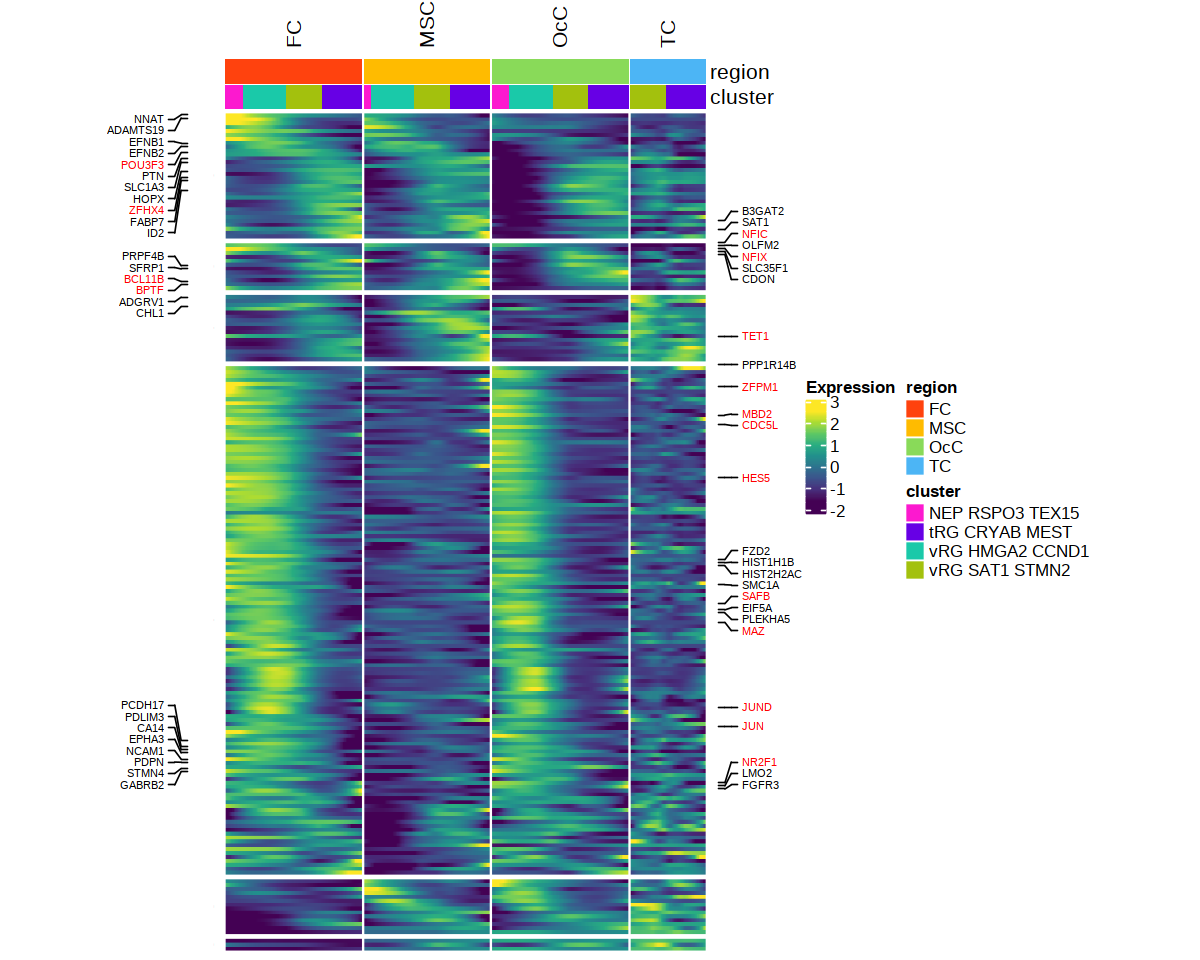

In [10]:
## Highlight TFs as red text
source("./ptime.fun.v2.R")
high_genes <- lapply(names(order_genes), function(pat) paste0(pat, "|", tfs)) %>%
            unlist()
rsplit <- strsplit(rownames(exp_mat), "|", fixed = TRUE) %>% 
                     sapply(., "[", 1) %>% 
                     factor(., levels = all_pats) %>%
                     setNames(., NULL)
                     
table(rsplit)[unique(rsplit)]

## Plot
ht <- plot_heatmap.RGCcascade.regionshare(mat = exp_mat, meta = trg_meta, 
                                    label_genes = sel_genes, 
                                    color_breaks = seq(-1.5, 2.5, 0.5), 
                                    file_name = paste0("Pairwise_Share_region_NESC-tRG"), 
                                    pdf_height = 6, row_split = rsplit, highlight_genes = high_genes, fontsize = 6)

## The gene labels are messed up in jupyter notebook, but will be normal if print in pdf
options(repr.plot.width=10, repr.plot.height=8)
draw(ht)

In [11]:
pdf("./report/Region-gradient_cascades_NESC-tRG_heatmap.pdf", width = 10, height = 6)
draw(ht)
dev.off() 

png 
  2

In [12]:
##------------------------------------------------------------------------------------------
## Plot Gene annotation & output annotation to tables
fil_pie <- readRDS(file = paste0("./load_files/", "Region_DEGs_pairwise_res.rds"))
fil_pie <- fil_pie %>% 
                ungroup() %>%
                relocate(TC, .after = OcC) %>%
                mutate(pattern = paste0(FC, "-", MSC, "-", OcC, "-", TC))

reg_tb <- NULL
ctp_tb <- NULL
for (pat in all_pats){
    sub_pie <- fil_pie %>% 
                filter(pattern == pat & feature %in% order_genes[[pat]])
    sub_pie <- sub_pie[match(order_genes[[pat]], sub_pie$feature), , drop = FALSE] 
    reg_mat <- sub_pie %>%
                ungroup() %>%
                select(FC, MSC, OcC, TC, feature) %>%
                column_to_rownames('feature')
    rownames(reg_mat) <- paste0(pat, "|", rownames(reg_mat))
    reg_tb <- rbind(reg_tb, reg_mat)


    ctp_mat <- fil_pie %>%
                ungroup() %>%
                mutate(cluster = as.factor(cluster)) %>%
                filter(pattern == pat & feature %in% order_genes[[pat]]) %>%
                select(feature, cluster) %>%
                mutate(nhit = 1) %>%
                reshape2::dcast(data = ., formula = feature ~ cluster, drop = FALSE, fun.aggregate = mean) %>%
                column_to_rownames("feature")
    ctp_mat <- ctp_mat[order_genes[[pat]], , drop = FALSE]
    ctp_mat[is.na(ctp_mat)] <- 0
    rownames(ctp_mat) <- paste0(pat, "|", rownames(ctp_mat))
    ctp_tb <- rbind(ctp_tb, ctp_mat)
}
head(reg_tb)
head(ctp_tb)
identical(rownames(reg_tb), rownames(ctp_tb))

Using nhit as value column: use value.var to override.

Using nhit as value column: use value.var to override.

Using nhit as value column: use value.var to override.

Using nhit as value column: use value.var to override.

Using nhit as value column: use value.var to override.

Using nhit as value column: use value.var to override.



,FC,MSC,OcC,TC
,<dbl>,<dbl>,<dbl>,<dbl>
1-1-0-0|NNAT,1,1,0,0
1-1-0-0|ADAMTS19,1,1,0,0
1-1-0-0|COL9A3,1,1,0,0
1-1-0-0|MDM1,1,1,0,0
1-1-0-0|RBP1,1,1,0,0
1-1-0-0|LRRN1,1,1,0,0


,vRG HMGA2 CCND1,vRG SAT1 STMN2
,<dbl>,<dbl>
1-1-0-0|NNAT,1,0
1-1-0-0|ADAMTS19,1,0
1-1-0-0|COL9A3,1,0
1-1-0-0|MDM1,1,0
1-1-0-0|RBP1,1,0
1-1-0-0|LRRN1,1,0


[1] TRUE

In [13]:
out_tb <- cbind(reg_tb, ctp_tb) %>%
            tibble::rownames_to_column("pattern_gene") %>%
            mutate(pattern = sapply(strsplit(pattern_gene, "|", fixed = TRUE), "[", 1)) %>%
            mutate(gene = sapply(strsplit(pattern_gene, "|", fixed = TRUE), "[", 2)) %>%
            select(-pattern_gene)
out_tb <- out_tb[, c("gene", "FC", "MSC", "OcC", "TC", "pattern", "vRG HMGA2 CCND1", "vRG SAT1 STMN2")]
reg_prefix <- "Region enrichment in "
colnames(out_tb) <- gsub("^FC$", paste0(reg_prefix, "Frontal"), colnames(out_tb)) %>%
                gsub("^MSC$", paste0(reg_prefix, "Mot.Som."), .) %>%
                gsub("^TC$", paste0(reg_prefix, "Temporal"), .) %>%
                gsub("^OcC$", paste0(reg_prefix, "Occipital"), .)
ctp_prefix <- "Subtype enrichment in "
colnames(out_tb) <- gsub("^vRG HMGA2 CCND1$", paste0(ctp_prefix, "vRG HMGA2 CCND1"), colnames(out_tb)) %>%
                gsub("^vRG SAT1 STMN2$", paste0(ctp_prefix, "vRG SAT1 STMN2"), .)
colnames(out_tb) <- gsub("^pattern$", "Gradient pattern", colnames(out_tb))
head(out_tb)
write.table(out_tb, file = "Region_gradient_table.txt", sep = "\t", quote = FALSE, 
            row.names = FALSE, col.names = TRUE)

,gene,Region enrichment in Frontal,Region enrichment in Mot.Som.,Region enrichment in Occipital,Region enrichment in Temporal,Gradient pattern,Subtype enrichment in vRG HMGA2 CCND1,Subtype enrichment in vRG SAT1 STMN2
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,NNAT,1,1,0,0,1-1-0-0,1,0
2,ADAMTS19,1,1,0,0,1-1-0-0,1,0
3,COL9A3,1,1,0,0,1-1-0-0,1,0
4,MDM1,1,1,0,0,1-1-0-0,1,0
5,RBP1,1,1,0,0,1-1-0-0,1,0
6,LRRN1,1,1,0,0,1-1-0-0,1,0


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(all_regs)` instead of `all_regs` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



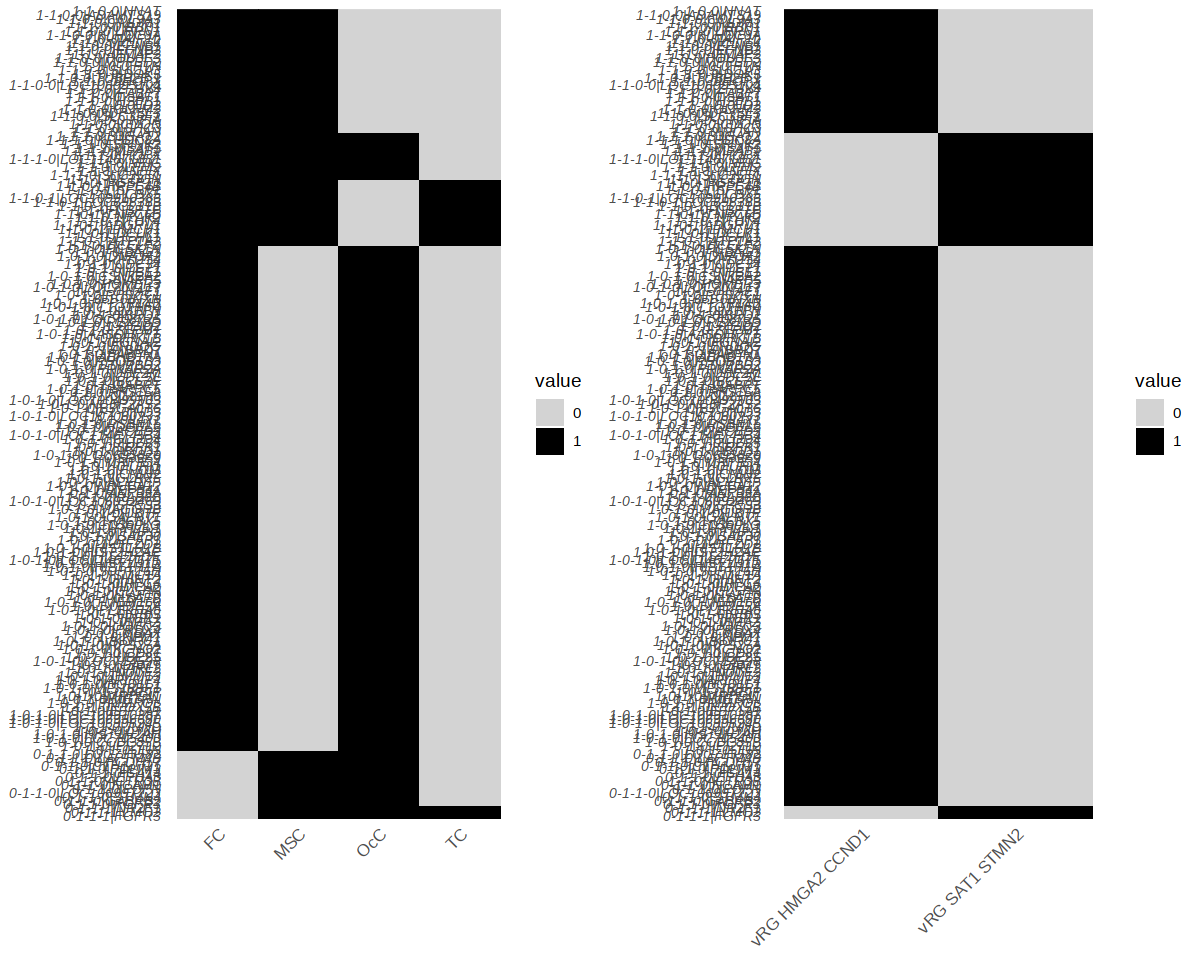

In [14]:
reg_annot <- reg_tb %>%
                as.data.frame() %>%
                rownames_to_column("gene") %>%
                tidyr::gather(., "region", "value", all_regs) %>%
                mutate(region = factor(region, levels = all_regs)) %>%
                mutate(gene = factor(gene, levels = rev(rownames(reg_tb)))) %>%
                mutate(value = as.character(value))
ctp_annot <- ctp_tb %>%
                as.data.frame() %>%
                rownames_to_column("gene") %>%
                tidyr::gather(., "cluster", "value", c("vRG HMGA2 CCND1", "vRG SAT1 STMN2")) %>%
                mutate(cluster = factor(cluster, levels = c("vRG HMGA2 CCND1", "vRG SAT1 STMN2"))) %>%
                mutate(gene = factor(gene, levels = rev(rownames(ctp_tb)))) %>%
                mutate(value = as.character(value))
p1 <- ggplot(reg_annot, aes_string(x = "region", y = "gene", fill = "value")) + 
            geom_tile(color = NA, size = 0.5) +
            scale_fill_manual(values = c(`0` = "lightgrey", `1` = "black")) +
            theme_classic() + 
            RotatedAxis() + 
            theme(axis.line = element_blank(), axis.ticks = element_blank(), 
                  axis.title = element_blank(), axis.text.y = element_text(size = 8, face = "italic"), 
                  axis.text.x = element_text(size = 10))
p2 <- ggplot(ctp_annot, aes_string(x = "cluster", y = "gene", fill = "value")) + 
            geom_tile(color = NA, size = 0.5) +
            scale_fill_manual(values = c(`0` = "lightgrey", `1` = "black")) +
            theme_classic() + 
            RotatedAxis() + 
            theme(axis.line = element_blank(), axis.ticks = element_blank(), 
                  axis.title = element_blank(), axis.text.y = element_text(size = 8, face = "italic"), 
                  axis.text.x = element_text(size = 10))
pcbn <- cowplot::plot_grid(p1, p2, nrow = 1, ncol = 2, align = "h")
pcbn

In [15]:
pdf(paste0(outputdir, "Pairwise_Share_region_NESC-tRG.annot-region.pdf"), width = 7, height = 6)
print(pcbn)
dev.off()

png 
  2

In [16]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/Tools/Anaconda3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] tidyr_1.1.3          ggforce_0.3.1        scatterpie_0.1.5    
 [4] ggplot2_3.3.0        ComplexHeatmap_2.2.0 circlize_0.4.13     
 [7] viridis_0.5.1        viridisLite_0.3.0    tibble_3.0.1        
[10] dplyr_1.0.7          Matrix_1.5-3     